# **Monkey Species Classification**



### **Context:**
Several species of monkeys have become extinct in recent years. As a result, a wildlife sanctuary in the United States has taken an important step forward in gathering data on all species that are currently endangered. They have collected images of monkeys from several continents. However, it has become difficult for them to organize all of these images into their respective categories. They require a solution to identify these images into their relevant monkey species groups. As a data scientist, you have to create an efficient model to classify these images into their respective categories.

### **Objective:**

Building a Convolutional Neural Network model to classify the monkey species into their respective categories.

### **Data Description:**

This dataset is taken from Kaggle and it consists of the various species of monkeys.
-  Due to the large volume of data, the images were converted to the images.npy file and the labels are also placed in Labels.csv, allowing you to work on the data without being concerned about the large data volume.
- The dataset comprises of 10 monkey species.

https://www.kaggle.com/datasets/slothkong/10-monkey-species


**List of Species**
- Mantled Howler
- Patas Monkey
- Bald Monkey
- Japanese Macaque
- Pygmy Marmoset
- White Headed Capuchin
- Silver Marmosetr
- Common Squirrel Monkey
- Black Headed Night Monkey
- Nilgiri Langur



#### **Note: Please use GPU runtime to execute the code efficiently**






## **Importing the necessary libraries**

In [1]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
import cv2
# Display images using OpenCV
#from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

2024-05-18 04:56:52.370350: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 04:56:52.370439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 04:56:52.474495: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Reading the dataset**

In [2]:
# Load the image file of the dataset
images = np.load('/kaggle/input/glcvweek3/images.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/kaggle/input/glcvweek3/Labels.csv')

## **Overview of the dataset**


Let's print the shape of the images and labels

In [5]:
print(images.shape)
print(labels.shape)

(1342, 128, 128, 3)
(1342, 1)


There are 1342 RGB  images of shape 128 x 128 X 3, each image having 3 channels.

## Plotting images using OpenCV and matplotlib

In [ ]:
#cv2.imshow(images[5])

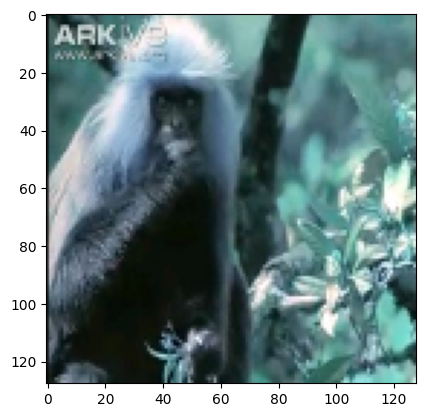

In [7]:
plt.imshow(images[9])

In [9]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

## **Exploratory Data Analysis**

In [10]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

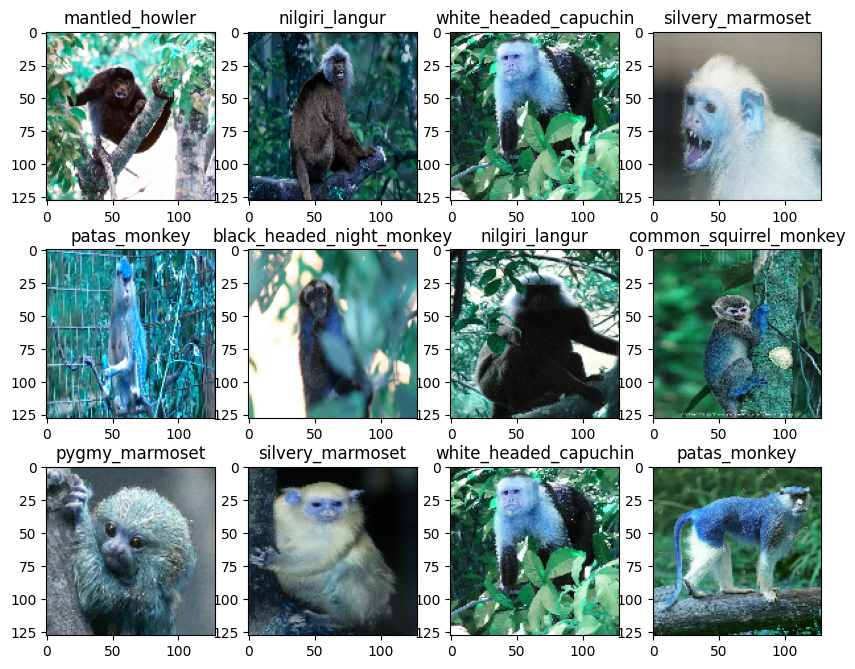

In [11]:
plot_images(images,labels)

<b> Checking for data imbalance

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'nilgiri_langur'),
  Text(1, 0, 'mantled_howler'),
  Text(2, 0, 'common_squirrel_monkey'),
  Text(3, 0, 'black_headed_night_monkey'),
  Text(4, 0, 'pygmy_marmoset'),
  Text(5, 0, 'japanese_macaque'),
  Text(6, 0, 'silvery_marmoset'),
  Text(7, 0, 'patas_monkey'),
  Text(8, 0, 'white_headed_capuchin'),
  Text(9, 0, 'bald_uakari')])

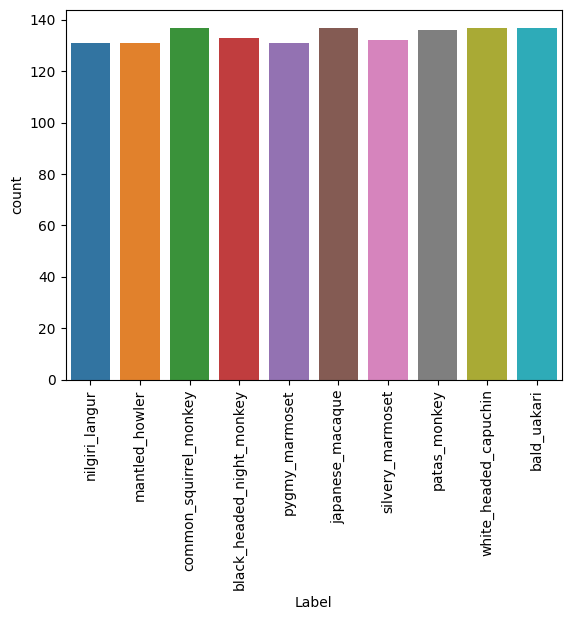

In [12]:
 sns.countplot(x=labels['Label'])
 plt.xticks(rotation='vertical')

- As you can see from the above plot, the dataset is quite balanced.
- There are about 135 images in each category

### Resizing images
As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [13]:
images_decreased=[]
height = 128
width = 128
# Epochs
epochs = 30
# Batch size
batch_size = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

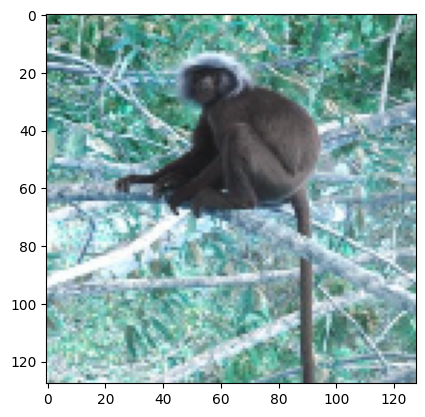

In [14]:
plt.imshow(images_decreased[3])

## Visualizing images using Gaussian Blur

In [15]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))


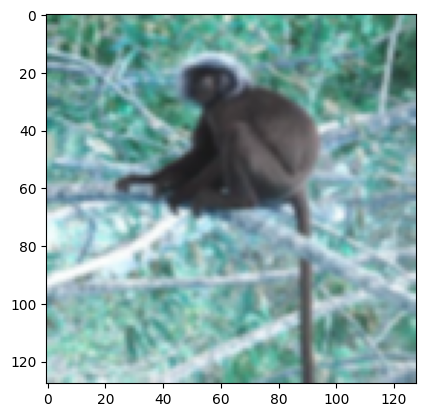

In [16]:
plt.imshow(images_gb[3])

- It appears that GaussianBlur would be ineffective because the blurred or denoised image does not seem to contain any relevant information, and the model would struggle to categorize these blurred images.

## **Splitting the dataset**

- As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.


### We will divide the original data set into
* Temp and test set
* Temp set is further divided into training and validation set

In [17]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)


In [18]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(1086, 128, 128, 3) (1086, 1)
(121, 128, 128, 3) (121, 1)
(135, 128, 128, 3) (135, 1)


## **Making the data compatible:**

- Convert labels from names to one hot vectors
- Normalizing the values


## Encoding the target labels

In [19]:
y_train

Label
1265                bald_uakari
891            silvery_marmoset
664            japanese_macaque
733            japanese_macaque
1252                bald_uakari
...                         ...
1009               patas_monkey
903            silvery_marmoset
726            japanese_macaque
489   black_headed_night_monkey
1181      white_headed_capuchin

[1086 rows x 1 columns]

In [20]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [ ]:
y_train_encoded

## Data Normalization
Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [26]:
# Normalizing the image pixels convert to float
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0


## **Model Building - Convolutional Neural Network (CNN)**
Let's create a CNN model sequentially, where we will be adding the layers one after another.

First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data.

In Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.

Also, let's fix the seed again after clearing the backend.

Let's **set the seed for random number generators in Numpy, the Random library in Python, and in TensorFlow** to be able to reproduce the same results every time we run the code.

In [29]:
# Clearing backend because previously you might user other frame work like keras ,So need to clear the selection
from tensorflow.keras import backend
backend.clear_session()

In [30]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Now, let's build a **CNN Model** with the following 2 main parts - <br>

1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers** for prediction.<br><br>


In [31]:
# Intializing a sequential model\
def CNN_Simple():
    model = Sequential()

    # Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
    # Input_shape denotes input image dimension of images
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(height, width, 3)))

    # Adding max pooling to reduce the size of output of first conv layer
    model.add(MaxPooling2D((2, 2), padding = 'same'))

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D((2, 2), padding = 'same'))

    # flattening the output of the conv layer after max pooling to make it ready for creating dense connections
    model.add(Flatten())

    # Adding a fully connected dense layer with 100 neurons
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    # Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
    model.add(Dense(10, activation='softmax'))

    # Using SGD Optimizer
    # opt = SGD(learning_rate=0.01, momentum=0.9)
    opt=Adam()
    # Compile model
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Generating the summary of the model
    model.summary()
    return model

In [ ]:
#cehcke the model architecture 
model_1 = CNN_Simple()
history_1 = model_1.fit(
            X_train_normalized, y_train_encoded,
            epochs=epochs,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=batch_size,
            verbose=2
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │       524,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 544,730 (2.08 MB)

 Trainable params: 544,730 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


I0000 00:00:1716008950.395115     186 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716008950.412641     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716008958.104848     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 - 19s - 1s/step - accuracy: 0.0820 - loss: 2.3140 - val_accuracy: 0.0992 - val_loss: 2.3023
Epoch 2/30
17/17 - 1s - 30ms/step - accuracy: 0.1004 - loss: 2.3027 - val_accuracy: 0.1488 - val_loss: 2.2957
Epoch 3/30
17/17 - 1s - 31ms/step - accuracy: 0.1050 - loss: 2.2944 - val_accuracy: 0.0992 - val_loss: 2.2816
Epoch 4/30
17/17 - 1s - 30ms/step - accuracy: 0.1740 - loss: 2.2296 - val_accuracy: 0.1983 - val_loss: 2.2036
Epoch 5/30
17/17 - 1s - 32ms/step - accuracy: 0.2063 - loss: 2.1353 - val_accuracy: 0.2479 - val_loss: 2.0906
Epoch 6/30
17/17 - 1s - 30ms/step - accuracy: 0.2523 - loss: 2.0621 - val_accuracy: 0.2479 - val_loss: 1.9932
Epoch 7/30
17/17 - 1s - 31ms/step - accuracy: 0.3241 - loss: 1.8825 - val_accuracy: 0.2314 - val_loss: 1.9747
Epoch 8/30
17/17 - 1s - 30ms/step - accuracy: 0.3241 - loss: 1.8081 - val_accuracy: 0.2727 - val_loss: 1.8886
Epoch 9/30
17/17 - 1s - 30ms/step - accuracy: 0.3840 - loss: 1.6669 - val_accuracy: 0.3306 - val_loss: 1.7973
Epoch 10/30
17/17 - 1s

### Model Evaluation

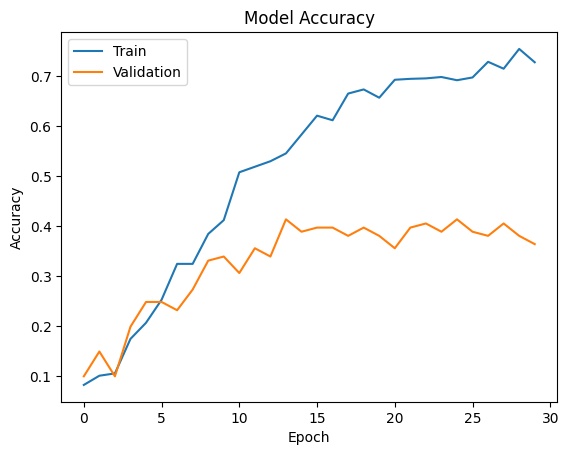

In [51]:
def plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
plot(history_1)

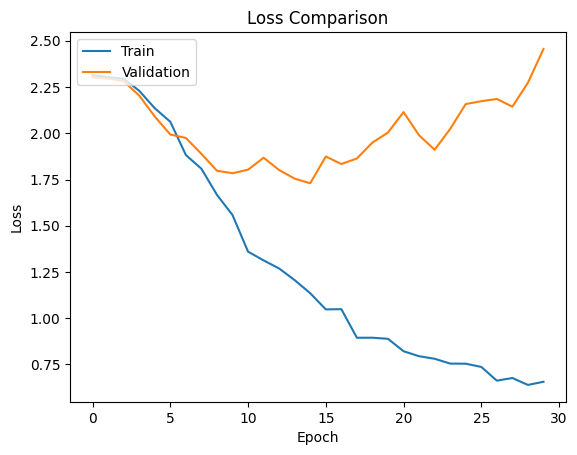

In [39]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss Comparison')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
plot(history_1)

### Check accuracy and predict on test

In [40]:
accuracytrain_1 = model_1.evaluate(X_train_normalized, y_train_encoded, verbose=2)
accuracy_1 = model_1.evaluate(X_test_normalized, y_test_encoded, verbose=2)
# Here we would get the output as probablities for each category
y_pred_1=model_1.predict(X_test_normalized)

34/34 - 4s - 103ms/step - accuracy: 0.9770 - loss: 0.1599
5/5 - 1s - 183ms/step - accuracy: 0.4815 - loss: 2.1994
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


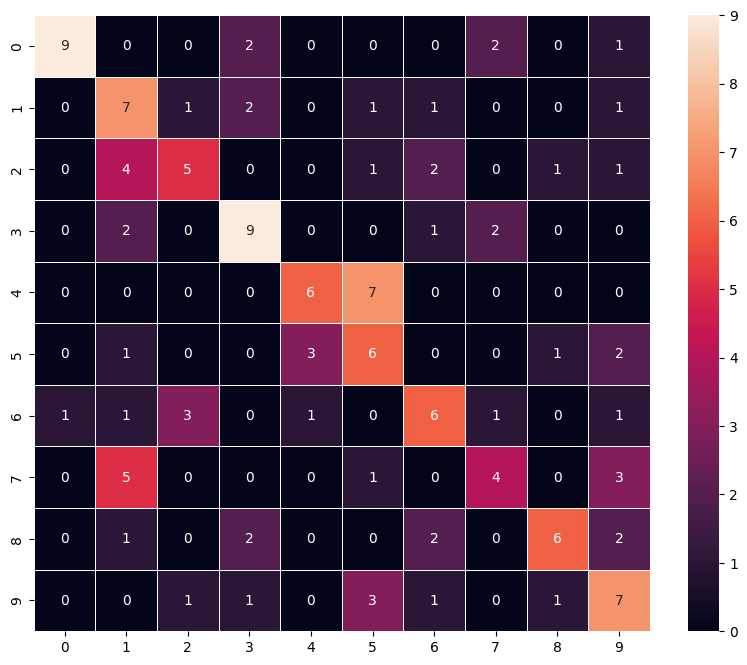

In [41]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg_1=np.argmax(y_pred_1,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg_1)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [42]:
print(classification_report(y_pred=y_pred_arg_1,y_true = y_test_arg))
#classifiaction report

              precision    recall  f1-score   support

           0       0.90      0.64      0.75        14
           1       0.33      0.54      0.41        13
           2       0.50      0.36      0.42        14
           3       0.56      0.64      0.60        14
           4       0.60      0.46      0.52        13
           5       0.32      0.46      0.37        13
           6       0.46      0.43      0.44        14
           7       0.44      0.31      0.36        13
           8       0.67      0.46      0.55        13
           9       0.39      0.50      0.44        14

    accuracy                           0.48       135
   macro avg       0.52      0.48      0.49       135
weighted avg       0.52      0.48      0.49       135



In [43]:
# Comparison table , saves the DF accuracy 
def update_results(method_name, accuracytrain,accuracy):
    Comparison = pd.DataFrame({'Method':[method_name], 'Train accuracy': accuracytrain,'Test accuracy': accuracy})
    Comparison = Comparison[['Method', 'Train accuracy','Test accuracy']]

    return Comparison


In [44]:
result_1 = update_results('CNN Simple',accuracytrain_1[1],accuracy_1[1])
result_1

Method  Train accuracy  Test accuracy
0  CNN Simple         0.97698       0.481481

### CNN Complex 
### 2nd model

In [45]:
def CNN_complex():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(height, width, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))

    model.add(Conv2D(64, (3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10,activation='softmax'))
    opt=Adam()
    # Compile model
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Generating the summary of the model
    model.summary()
    return model

### <b> Fitting the model on the train data

In [47]:
def callback():
    filepath=str("model.keras")
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    stop = EarlyStopping(monitor='val_acc', patience=5,mode='max')
    callbacks_list = [checkpoint,stop]#, stopper]
    return callbacks_list


In [48]:
model_2 = CNN_complex()
callbacks_list = callback()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 30, 30, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,493,738 (24.77 MB)

 Trainable params: 6,493,738 (24.77 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history_2 = model_2.fit(
            X_train_normalized, y_train_encoded,
            epochs=epochs,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=batch_size,
            verbose=1,
            callbacks=callbacks_list
)

Epoch 1/30
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1181 - loss: 2.3229

W0000 00:00:1716009391.002652     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.1592 - loss: 2.2800

W0000 00:00:1716009398.982592     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716009399.772291     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 680ms/step - accuracy: 0.1615 - loss: 2.2759 - val_accuracy: 0.2975 - val_loss: 2.0133
Epoch 2/30
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3597 - loss: 1.8966

W0000 00:00:1716009401.904939     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3560 - loss: 1.8794 - val_accuracy: 0.3884 - val_loss: 1.7241
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5105 - loss: 1.4863 - val_accuracy: 0.4215 - val_loss: 1.5570
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6044 - loss: 1.2232 - val_accuracy: 0.4793 - val_loss: 1.5114
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6570 - loss: 1.0326 - val_accuracy: 0.5041 - val_loss: 1.5082
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7052 - loss: 0.8066 - val_accuracy: 0.4793 - val_loss: 1.5145
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7758 - loss: 0.6457 - val_accuracy: 0.5124 - val_loss: 1.6860
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8135 - loss: 0.5641 - val_accuracy: 0.5372 - val_loss: 1.6373
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8335 - loss: 0.4388 - val_accuracy: 0.4793 - val_loss: 1.

### **Model Evaluation**

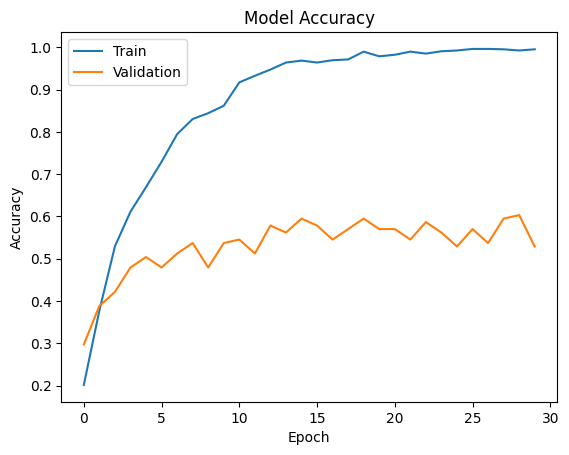

In [52]:
plot(history_2)

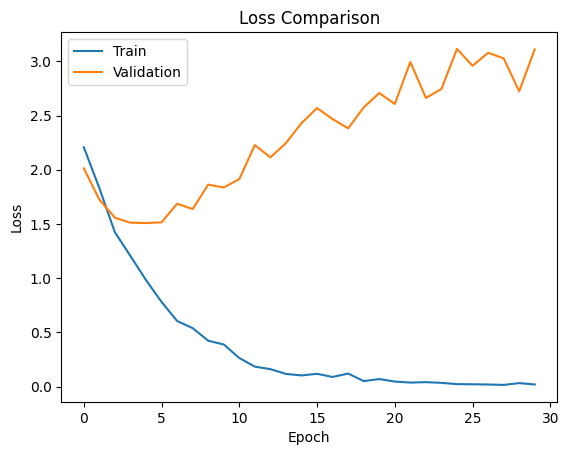

In [53]:
plot_loss(history_2)

**Observations:**


*   We can see from the above plot that **the training accuracy of the  model was good but the validation accuracy was not good.**
*   The model seems to overfit on the data.






### **Evaluating the model on test data**

In [54]:
accuracytrain_2 = model_2.evaluate(X_train_normalized, y_train_encoded, verbose=2)
accuracy_2= model_2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

W0000 00:00:1716009515.260043     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 - 3s - 97ms/step - accuracy: 0.9991 - loss: 0.0088


W0000 00:00:1716009516.928065     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 - 1s - 215ms/step - accuracy: 0.6444 - loss: 2.7205


W0000 00:00:1716009518.087509     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### **Generating the predictions using test data**

In [55]:
# Here we would get the output as probablities for each category
y_pred_2=model_2.predict(X_test_normalized)

1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step

W0000 00:00:1716009518.513808     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


W0000 00:00:1716009518.870315     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### **Plotting the Confusion Matrix**

*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.





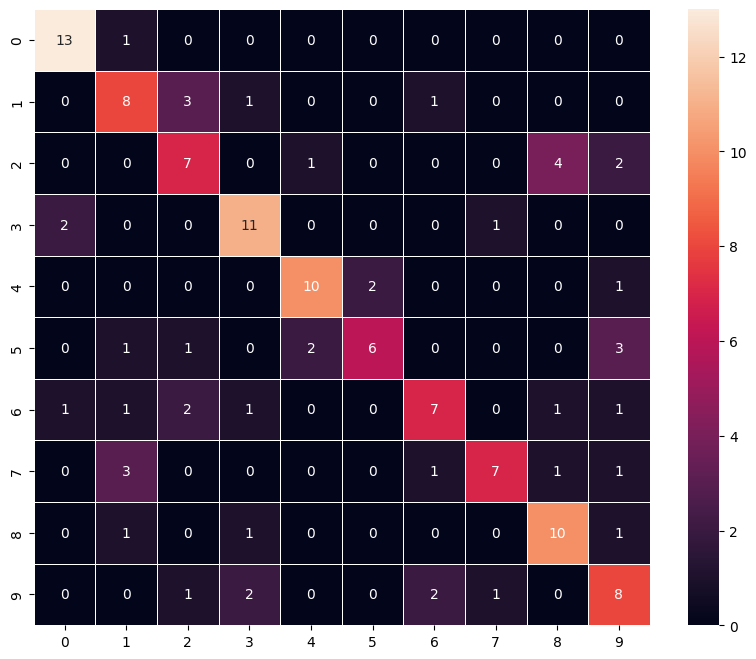

In [56]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg_2=np.argmax(y_pred_2,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg_2)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- We observe that some of the classes are not predicted correctly.
- In comparison to the rest, we can see that classes 0,3, and 4 are well classified.
- We can also observe that classes 1,2,5,7 and 9 are mostly misclassified.

In [57]:
print(classification_report(y_pred=y_pred_arg_2,y_true = y_test_arg))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87        14
           1       0.53      0.62      0.57        13
           2       0.50      0.50      0.50        14
           3       0.69      0.79      0.73        14
           4       0.77      0.77      0.77        13
           5       0.75      0.46      0.57        13
           6       0.64      0.50      0.56        14
           7       0.78      0.54      0.64        13
           8       0.62      0.77      0.69        13
           9       0.47      0.57      0.52        14

    accuracy                           0.64       135
   macro avg       0.66      0.64      0.64       135
weighted avg       0.65      0.64      0.64       135



In [58]:
result_2 = update_results('CNN Complex',accuracytrain_2[1],accuracy_2[1])
results = pd.concat([result_1, result_2])
results

Method  Train accuracy  Test accuracy
0   CNN Simple        0.976980       0.481481
0  CNN Complex        0.999079       0.644444

# Model-2

As we can see, our initial model appears to overfit. Therefore we'll try to address this problem with data augmentation and Batch Normalization to check if we can improve the model's performance.

## **Data Augmentation**

In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs. To overcome this problem, one approach we might consider is **Data Augmentation**. CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. <br> Taking this attribute into account, we can augment the images using the techniques listed below - <br>
**1. Horizontal Flip** (should be set to True/False) <br>
**2. Vertical Flip** (should be set to True/False) <br>
**3. Height Shift** (should be between 0 and 1) <br>
**4. Width Shift** (should be between 0 and 1) <br>
**5. Rotation** (should be between 0 and 180) <br>
**6. Shear** (should be between 0 and 1) <br>
**7. Zoom** (should be between 0 and 1) etc. <br>

Remember, **data augmentation should not be used in the validation/test data set**.

In [66]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# # All images to be rescaled by 1/255.
# train_datagen = ImageDataGenerator(
#                               rotation_range=20,
#                               fill_mode='nearest'
#                               )
# # test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [67]:
# Training generator
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


In [68]:
model_3 = CNN_Simple()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       524,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 544,730 (2.08 MB)

 Trainable params: 544,730 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
history_3 = model_3.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 1:15 5s/step - accuracy: 0.1406 - loss: 2.3090

W0000 00:00:1716009784.865657     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step - accuracy: 0.1042 - loss: 2.3509 - val_accuracy: 0.1074 - val_loss: 2.2898
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0938 - loss: 2.3009 - val_accuracy: 0.0992 - val_loss: 2.2856
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.1286 - loss: 2.2884 - val_accuracy: 0.1488 - val_loss: 2.2261
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1406 - loss: 2.2555 - val_accuracy: 0.1653 - val_loss: 2.2190
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.1733 - loss: 2.2549 - val_accuracy: 0.2645 - val_loss: 2.1472
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2969 - loss: 2.0934 - val_accuracy: 0.2645 - val_loss: 2.1326
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.2012 - loss: 2.1898 - val_accuracy: 0.2066 - val_loss: 2.1213
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2031 - loss: 2.1257 - val_accuracy: 0.1983 - val_loss: 2

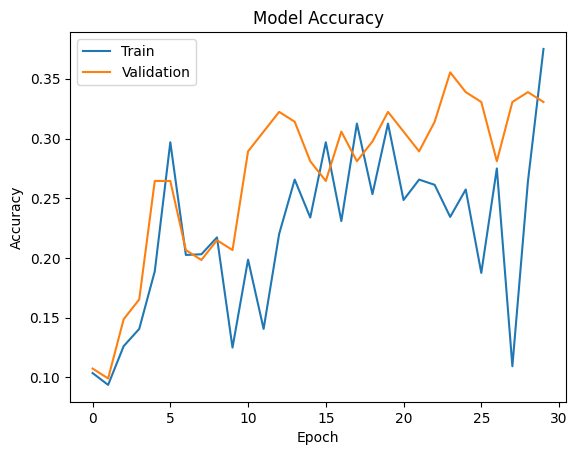

In [70]:
plot(history_3)

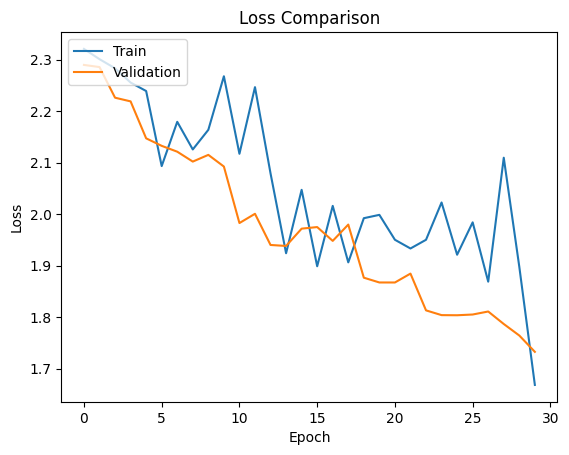

In [71]:
plot_loss(history_3)

### Evaluate and predict on test set

In [72]:
accuracytrain_3 = model_3.evaluate(X_train_normalized, y_train_encoded, verbose=2)
accuracy_3 = model_3.evaluate(X_test_normalized, y_test_encoded, verbose=2)
# Here we would get the output as probablities for each category
y_pred_3=model_3.predict(X_test_normalized)

34/34 - 1s - 22ms/step - accuracy: 0.3895 - loss: 1.5900
5/5 - 0s - 83ms/step - accuracy: 0.3556 - loss: 1.6336
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


We can observe that our accuracy has improved compared to our previous model.

### Confusion matrix

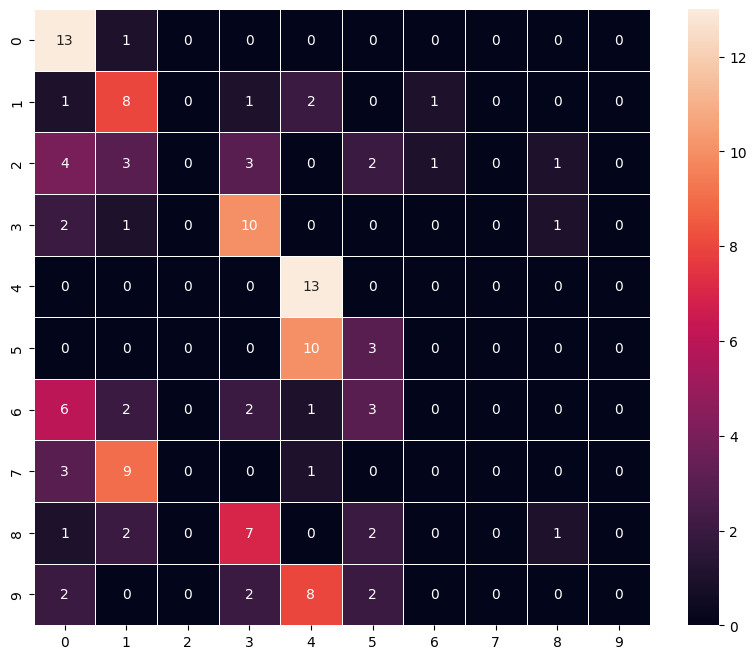

In [73]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg_3=np.argmax(y_pred_3,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg_3)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Observation:**
- The confusion matrix appears to be improving as well, however there is still some confusion with the 3,5,7 classes of monkey species.
- The 5th class is the most confused class among all.
- We can observe that this model has outperformed our previous model.

In [74]:

print(classification_report(y_pred=y_pred_arg_3,y_true = y_test_arg))

              precision    recall  f1-score   support

           0       0.41      0.93      0.57        14
           1       0.31      0.62      0.41        13
           2       0.00      0.00      0.00        14
           3       0.40      0.71      0.51        14
           4       0.37      1.00      0.54        13
           5       0.25      0.23      0.24        13
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        13
           8       0.33      0.08      0.12        13
           9       0.00      0.00      0.00        14

    accuracy                           0.36       135
   macro avg       0.21      0.36      0.24       135
weighted avg       0.21      0.36      0.24       135



In [75]:
result_3 = update_results('CNN Simple with Data_aug',accuracytrain_3[1],accuracy_3[1])
results = pd.concat([results, result_3])
results

Method  Train accuracy  Test accuracy
0                CNN Simple        0.976980       0.481481
0               CNN Complex        0.999079       0.644444
0  CNN Simple with Data_aug        0.389503       0.355556

### Data Augmentation with complex CNN design

In [76]:
model_4 = CNN_complex()
callbacklist = callback()


history_4 = model_4.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1,callbacks=callbacklist)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,493,738 (24.77 MB)

 Trainable params: 6,493,738 (24.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 1:49 7s/step - accuracy: 0.0938 - loss: 2.3143

W0000 00:00:1716010019.328907     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 8/16 ━━━━━━━━━━━━━━━━━━━━ 5s 659ms/step - accuracy: 0.1027 - loss: 2.3386

W0000 00:00:1716010023.869012     185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.1053 - loss: 2.3210

W0000 00:00:1716010025.466014     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 503ms/step - accuracy: 0.1063 - loss: 2.3194 - val_accuracy: 0.1653 - val_loss: 2.1992
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1719 - loss: 2.1920 - val_accuracy: 0.1818 - val_loss: 2.2129
Epoch 3/30


W0000 00:00:1716010026.898861     185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.1947 - loss: 2.1869 - val_accuracy: 0.1736 - val_loss: 2.0520
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2969 - loss: 1.9037 - val_accuracy: 0.2562 - val_loss: 2.0045
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.2562 - loss: 1.9640 - val_accuracy: 0.3306 - val_loss: 1.8787
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2188 - loss: 1.9506 - val_accuracy: 0.3471 - val_loss: 1.8598
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.3263 - loss: 1.8511 - val_accuracy: 0.2479 - val_loss: 2.1610
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4531 - loss: 1.7170 - val_accuracy: 0.2397 - val_loss: 2.3179
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.3611 - loss: 1.7746 - val_accuracy: 0.4215 - val_loss: 1.6507
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4375 - loss: 1.6317 - val_accuracy: 0.4050 - val_loss: 1

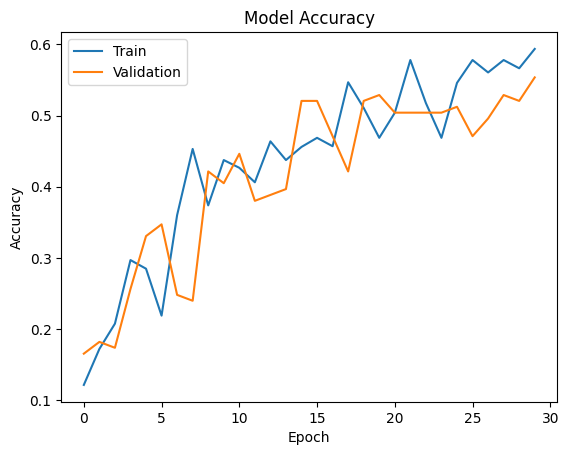

In [77]:
plot(history_4)

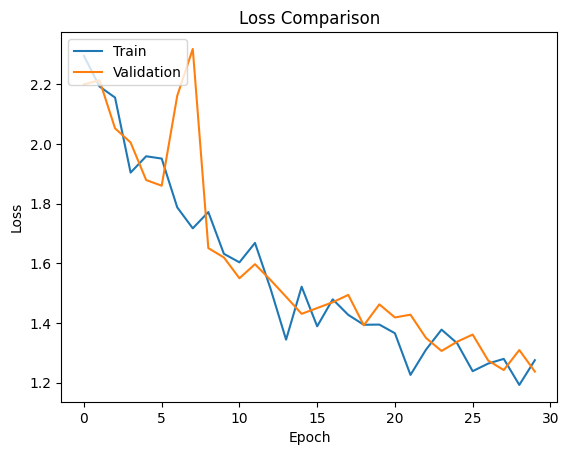

In [78]:
plot_loss(history_4)

### Evaluate and predict on test data

In [79]:
accuracytrain_4 = model_4.evaluate(X_train_normalized, y_train_encoded, verbose=2)
accuracy_4 = model_4.evaluate(X_test_normalized, y_test_encoded, verbose=2)
# Here we would get the output as probablities for each category
y_pred_4=model_4.predict(X_test_normalized)

34/34 - 1s - 23ms/step - accuracy: 0.6971 - loss: 0.9388


W0000 00:00:1716010116.015558     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 - 0s - 90ms/step - accuracy: 0.6148 - loss: 1.0588


W0000 00:00:1716010117.011728     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step

W0000 00:00:1716010117.622016     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


W0000 00:00:1716010118.000358     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Confusion matrix

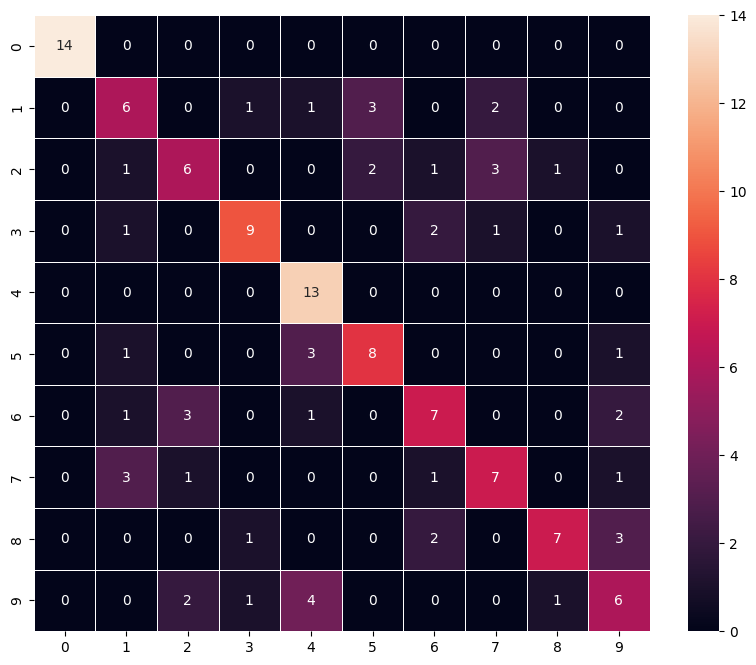

In [80]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg_4=np.argmax(y_pred_4,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg_4)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [81]:
print(classification_report(y_pred=y_pred_arg_4,y_true = y_test_arg))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.46      0.46      0.46        13
           2       0.50      0.43      0.46        14
           3       0.75      0.64      0.69        14
           4       0.59      1.00      0.74        13
           5       0.62      0.62      0.62        13
           6       0.54      0.50      0.52        14
           7       0.54      0.54      0.54        13
           8       0.78      0.54      0.64        13
           9       0.43      0.43      0.43        14

    accuracy                           0.61       135
   macro avg       0.62      0.62      0.61       135
weighted avg       0.62      0.61      0.61       135



In [82]:
result_4 = update_results('CNN Complex with Data_aug',accuracytrain_4[1],accuracy_4[1])
results = pd.concat([results, result_4])
results

Method  Train accuracy  Test accuracy
0                 CNN Simple        0.976980       0.481481
0                CNN Complex        0.999079       0.644444
0   CNN Simple with Data_aug        0.389503       0.355556
0  CNN Complex with Data_aug        0.697053       0.614815

# Transfer Learning using VGG16

- Let's try again, but this time, we will be using the idea of **Transfer Learning**. We will be loading a pre-built architecture - **VGG16**, which was trained on the ImageNet dataset and is the runner-up in the ImageNet competition in 2014.

- For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem.


In [83]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

In [87]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (height,width,3))
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
def VGG():
    vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (height,width,3))
    vgg_model.summary()
    # Making all the layers of the VGG model non-trainable. i.e. freezing themthe weights
    for layer in vgg_model.layers:
        layer.trainable = False
    new_model = Sequential()

    # Adding the convolutional part of the VGG16 model from above
    new_model.add(vgg_model)

    # Flattening the output of the VGG16 model because it is from a convolutional layer
    new_model.add(Flatten())

    # Adding a dense output layer
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(64, activation='relu'))
    new_model.add(Dense(10, activation='softmax'))
    opt=Adam()
    # Compile model
    new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Generating the summary of the model
    new_model.summary()
    return new_model

In [89]:
new_model= VGG()
callback_list = callback()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [90]:
history_vgg16 = new_model.fit(
            X_train_normalized, y_train_encoded,
            epochs=epochs,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=batch_size,
            verbose=1,callbacks=callback_list)

Epoch 1/30
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.1055 - loss: 2.6952 

W0000 00:00:1716010474.720701     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1765 - loss: 2.3503  

W0000 00:00:1716010498.251150     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716010499.432476     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.1814 - loss: 2.3369 - val_accuracy: 0.4959 - val_loss: 1.5448
Epoch 2/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.5781 - loss: 1.3888

W0000 00:00:1716010519.079506     185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.5717 - loss: 1.3104 - val_accuracy: 0.6446 - val_loss: 1.1305
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.7529 - loss: 0.7970 - val_accuracy: 0.6777 - val_loss: 0.9853
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8427 - loss: 0.5263 - val_accuracy: 0.7438 - val_loss: 0.8094
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9002 - loss: 0.3401 - val_accuracy: 0.7438 - val_loss: 0.8091
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9461 - loss: 0.2300 - val_accuracy: 0.7686 - val_loss: 0.8128
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9664 - loss: 0.1578 - val_accuracy: 0.7521 - val_loss: 0.7712
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9739 - loss: 0.1181 - val_accuracy: 0.7686 - val_loss: 0.7518
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9815 - loss: 0.0999 - val_accuracy: 0.7273 - val_loss: 0.

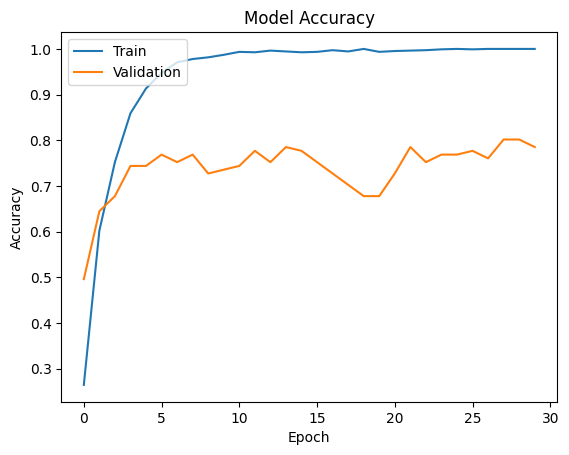

In [91]:
plot(history_vgg16)

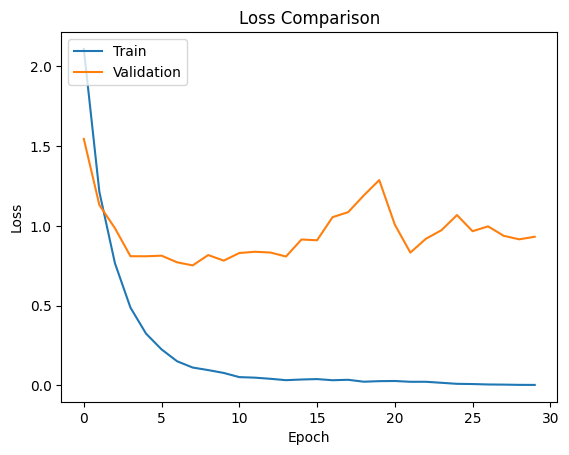

In [92]:
plot_loss(history_vgg16)

In [93]:
accuracytrain_vgg16 = new_model.evaluate(X_train_normalized, y_train_encoded, verbose=2)
accuracy_vgg16 = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

W0000 00:00:1716010606.750055     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 - 26s - 760ms/step - accuracy: 1.0000 - loss: 4.3708e-04


W0000 00:00:1716010620.171767     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 - 5s - 1s/step - accuracy: 0.8222 - loss: 0.7238


W0000 00:00:1716010640.435247     185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [94]:
# Here we would get the output as probablities for each category
y_pred_vgg16=new_model.predict(X_test_normalized)

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 

W0000 00:00:1716010641.292652     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step


W0000 00:00:1716010642.113751     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


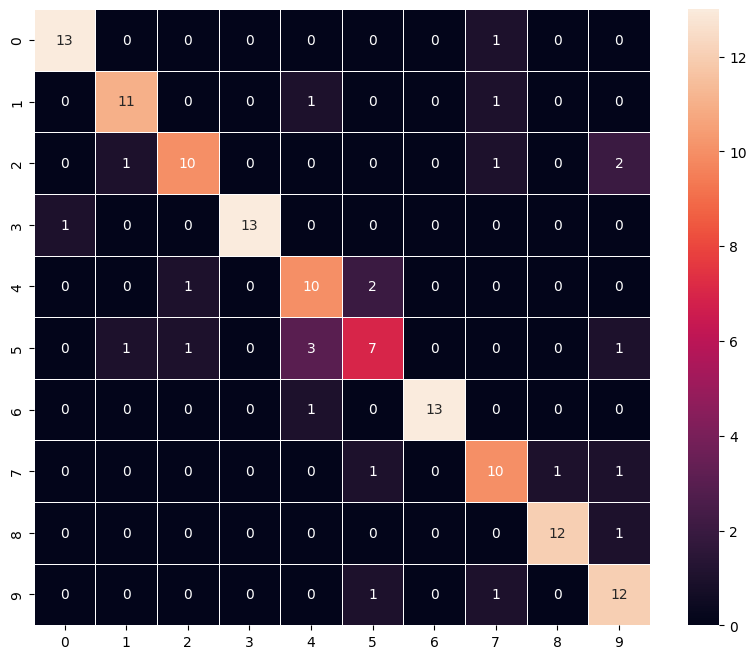

In [95]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg_vgg16=np.argmax(y_pred_vgg16,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg_vgg16)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

- According to the confusion matrix and accuracy curve, the VGG16 model has outperformed Model-2.
- Thus we can say that VGG16 is our best model and we can use this model to predict and visualize some test images.

In [96]:
print(classification_report(y_pred=y_pred_arg_vgg16,y_true = y_test_arg))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.85      0.85      0.85        13
           2       0.83      0.71      0.77        14
           3       1.00      0.93      0.96        14
           4       0.67      0.77      0.71        13
           5       0.64      0.54      0.58        13
           6       1.00      0.93      0.96        14
           7       0.71      0.77      0.74        13
           8       0.92      0.92      0.92        13
           9       0.71      0.86      0.77        14

    accuracy                           0.82       135
   macro avg       0.83      0.82      0.82       135
weighted avg       0.83      0.82      0.82       135



In [97]:
result_vgg16 = update_results('VGG16',accuracytrain_vgg16[1],accuracy_vgg16[1])
results = pd.concat([results, result_vgg16])
results

Method  Train accuracy  Test accuracy
0                 CNN Simple        0.976980       0.481481
0                CNN Complex        0.999079       0.644444
0   CNN Simple with Data_aug        0.389503       0.355556
0  CNN Complex with Data_aug        0.697053       0.614815
0                      VGG16        1.000000       0.822222

### VGG with data aug

In [98]:
vgg_data_aug = VGG()
callbacklist = callback()


history_VGG16_aug = vgg_data_aug.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1,callbacks=callbacklist)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30
 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.0508 - loss: 2.8543

W0000 00:00:1716010702.051531     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 8/16 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step - accuracy: 0.0888 - loss: 2.7324

W0000 00:00:1716010705.012767     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.1178 - loss: 2.5993

W0000 00:00:1716010706.837932     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.1202 - loss: 2.5886 - val_accuracy: 0.2149 - val_loss: 1.9958
Epoch 2/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.1562 - loss: 2.2299

W0000 00:00:1716010717.351464     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1562 - loss: 2.2299 - val_accuracy: 0.2314 - val_loss: 1.9716
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.3186 - loss: 1.9489 - val_accuracy: 0.5041 - val_loss: 1.4607
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3594 - loss: 1.7170 - val_accuracy: 0.5620 - val_loss: 1.4035
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.4811 - loss: 1.5150 - val_accuracy: 0.6612 - val_loss: 1.1688
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5469 - loss: 1.3942 - val_accuracy: 0.6446 - val_loss: 1.1865
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.5985 - loss: 1.1813 - val_accuracy: 0.7025 - val_loss: 0.9462
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5469 - loss: 1.1986 - val_accuracy: 0.6694 - val_loss: 0.9600
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.6418 - loss: 1.0622 - val_accuracy: 0.7025 - val_loss

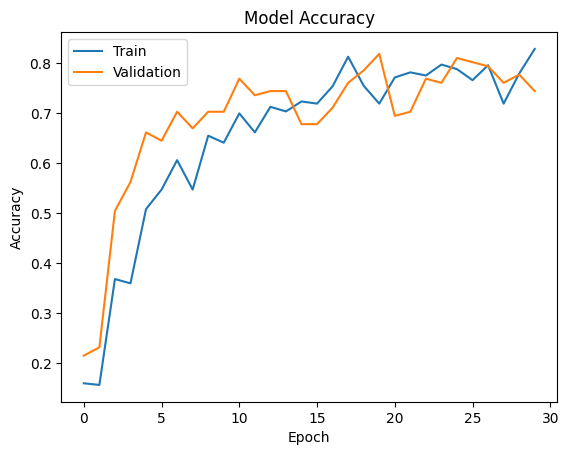

In [99]:
plot(history_VGG16_aug)

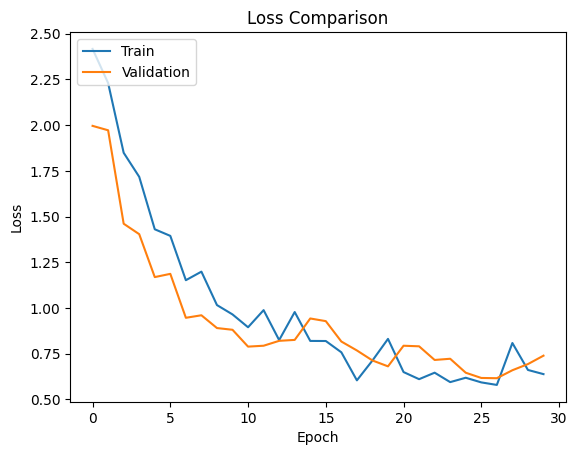

In [101]:
plot_loss(history_VGG16_aug)

### Evaluaton and predict on test set

In [102]:
accuracytrain_vgg16_aug = vgg_data_aug.evaluate(X_train_normalized, y_train_encoded, verbose=2)
accuracy_vgg16_aug = vgg_data_aug.evaluate(X_test_normalized, y_test_encoded, verbose=2)
# Here we would get the output as probablities for each category
y_pred_vgg16_aug=vgg_data_aug.predict(X_test_normalized)

34/34 - 2s - 57ms/step - accuracy: 0.8775 - loss: 0.3481


W0000 00:00:1716010835.405279     185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 - 1s - 126ms/step - accuracy: 0.7778 - loss: 0.6257


W0000 00:00:1716010836.142124     185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 

W0000 00:00:1716010836.762104     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


W0000 00:00:1716010837.404120     185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Confusion matrix

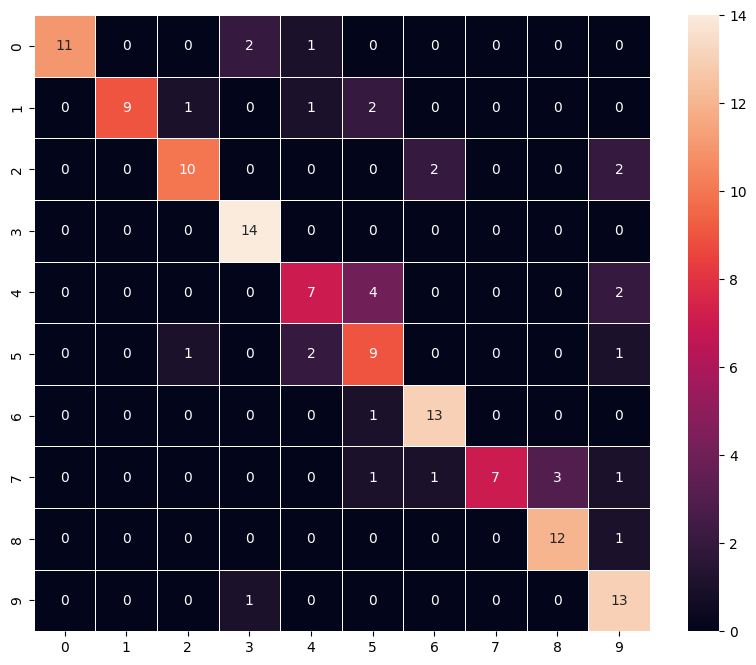

In [103]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg_vgg16_aug=np.argmax(y_pred_vgg16_aug,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg_vgg16_aug)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [104]:
print(classification_report(y_pred=y_pred_arg_vgg16_aug,y_true = y_test_arg))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        14
           1       1.00      0.69      0.82        13
           2       0.83      0.71      0.77        14
           3       0.82      1.00      0.90        14
           4       0.64      0.54      0.58        13
           5       0.53      0.69      0.60        13
           6       0.81      0.93      0.87        14
           7       1.00      0.54      0.70        13
           8       0.80      0.92      0.86        13
           9       0.65      0.93      0.76        14

    accuracy                           0.78       135
   macro avg       0.81      0.77      0.77       135
weighted avg       0.81      0.78      0.78       135



In [105]:
result_vgg16_aug = update_results('VGG16 with aug',accuracytrain_vgg16_aug[1],accuracy_vgg16_aug[1])
results = pd.concat([results, result_vgg16_aug])
results

Method  Train accuracy  Test accuracy
0                 CNN Simple        0.976980       0.481481
0                CNN Complex        0.999079       0.644444
0   CNN Simple with Data_aug        0.389503       0.355556
0  CNN Complex with Data_aug        0.697053       0.614815
0                      VGG16        1.000000       0.822222
0             VGG16 with aug        0.877532       0.777778

In [112]:
enc.inverse_transform(vgg_data_aug.predict((X_test_normalized[2].reshape(1,height,width,3))))
enc.inverse_transform(y_test_encoded)[2]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


'bald_uakari'

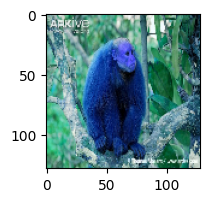

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Label:  bald_uakari
True Label:  bald_uakari




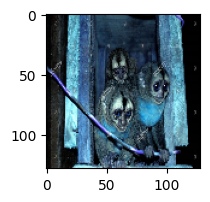

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Label:  black_headed_night_monkey
True Label:  black_headed_night_monkey




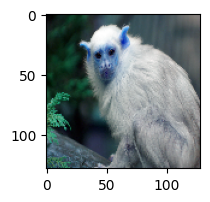

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Label:  silvery_marmoset
True Label:  silvery_marmoset


In [113]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label: ', enc.inverse_transform(vgg_data_aug.predict((X_test_normalized[2].reshape(1,height,width,3))))[0])   # reshaping the input image as we are only trying to predict using a single image
print('True Label: ', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector
print("\n")
plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label: ', enc.inverse_transform(vgg_data_aug.predict((X_test_normalized[33].reshape(1,height,width,3))))[0])  # reshaping the input image as we are only trying to predict using a single image
print('True Label: ', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector
print("\n")
plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label: ', enc.inverse_transform(vgg_data_aug.predict((X_test_normalized[36].reshape(1,height,width,3))))[0])  # reshaping the input image as we are only trying to predict using a single image
print('True Label: ', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

### Xception 

In [114]:
from keras.applications.xception import Xception

In [115]:
def Xception_model():
    xception_model = Xception(weights='imagenet', include_top = False, input_shape = (height,width,3))
    xception_model.summary()
    # Making all the layers of the VGG model non-trainable. i.e. freezing them
    for layer in xception_model.layers:
        layer.trainable = False
    new_model = Sequential()

    # Adding the convolutional part of the VGG16 model from above
    new_model.add(xception_model)

    # Flattening the output of the VGG16 model because it is from a convolutional layer
    new_model.add(Flatten())

    # Adding a dense output layer
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(10, activation='softmax'))
    opt=Adam()
    # Compile model
    new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Generating the summary of the model
    new_model.summary()
    return new_model

In [116]:
xception_model= Xception_model()
callback_list = callback()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer_9[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 31, 31,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [117]:
history_xception = xception_model.fit(
            X_train_normalized, y_train_encoded,
            epochs=epochs,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=batch_size,
            verbose=1,callbacks=callback_list)

Epoch 1/30
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.0820 - loss: 9.9771 

W0000 00:00:1716011066.764332     185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.2399 - loss: 17.2533

W0000 00:00:1716011080.328030     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716011083.560611     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.2474 - loss: 17.0087 - val_accuracy: 0.6198 - val_loss: 1.8643
Epoch 2/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6406 - loss: 1.1919

W0000 00:00:1716011093.347912     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.6680 - loss: 1.3126 - val_accuracy: 0.7355 - val_loss: 0.9545
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7503 - loss: 0.7566 - val_accuracy: 0.7107 - val_loss: 0.8124
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.7837 - loss: 0.6739 - val_accuracy: 0.7521 - val_loss: 0.7564
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8618 - loss: 0.4247 - val_accuracy: 0.7851 - val_loss: 0.7691
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8879 - loss: 0.3571 - val_accuracy: 0.7769 - val_loss: 0.8851
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9035 - loss: 0.2859 - val_accuracy: 0.7769 - val_loss: 0.8633
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9186 - loss: 0.2871 - val_accuracy: 0.8017 - val_loss: 0.8822
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9153 - loss: 0.2666 - val_accuracy: 0.7934 - val_loss: 0.

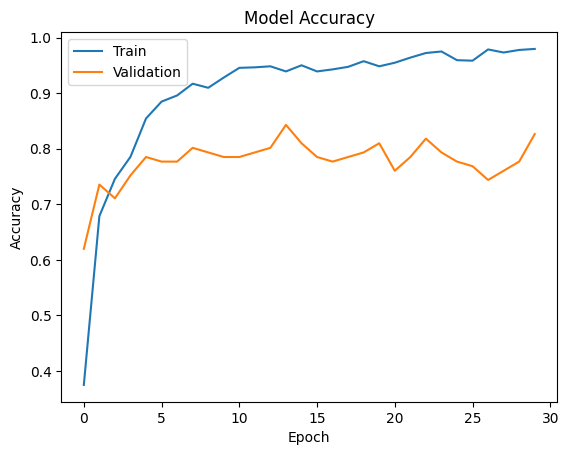

In [118]:
plot(history_xception)

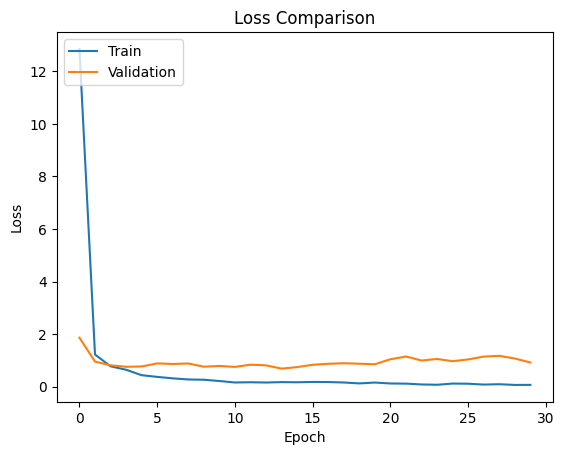

In [130]:
plot_loss(history_xception)

### Evaluaton and predict on test set

In [119]:
accuracytrain_xception = xception_model.evaluate(X_train_normalized, y_train_encoded, verbose=2)
accuracy_xception = xception_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)
# Here we would get the output as probablities for each category
y_pred_xception=xception_model.predict(X_test_normalized)

W0000 00:00:1716011146.952758     185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 - 14s - 413ms/step - accuracy: 1.0000 - loss: 0.0016


W0000 00:00:1716011154.489938     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 - 4s - 847ms/step - accuracy: 0.8593 - loss: 0.6335


W0000 00:00:1716011158.807260     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

W0000 00:00:1716011161.673802     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 720ms/step


W0000 00:00:1716011164.552853     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Confusion Matrix

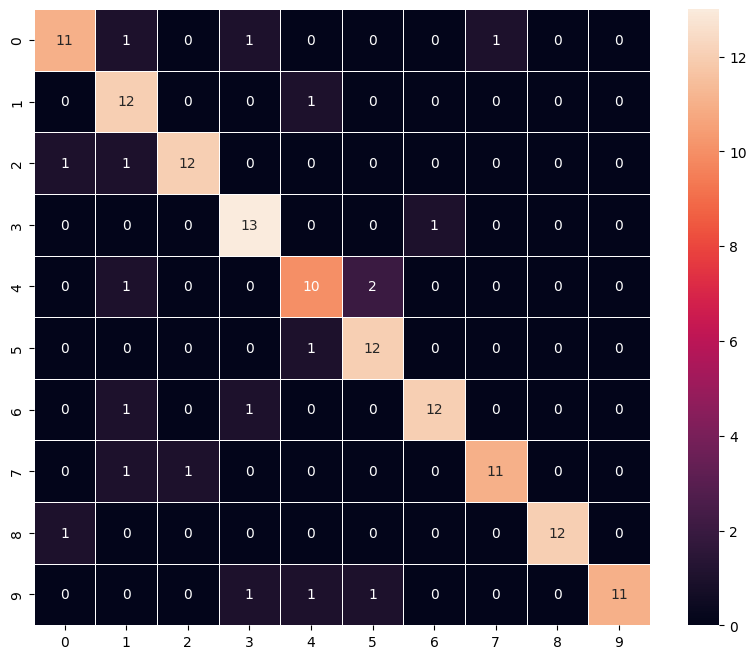

In [120]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg_xception=np.argmax(y_pred_xception,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg_xception)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [121]:
print(classification_report(y_pred=y_pred_arg_xception,y_true = y_test_arg))

              precision    recall  f1-score   support

           0       0.85      0.79      0.81        14
           1       0.71      0.92      0.80        13
           2       0.92      0.86      0.89        14
           3       0.81      0.93      0.87        14
           4       0.77      0.77      0.77        13
           5       0.80      0.92      0.86        13
           6       0.92      0.86      0.89        14
           7       0.92      0.85      0.88        13
           8       1.00      0.92      0.96        13
           9       1.00      0.79      0.88        14

    accuracy                           0.86       135
   macro avg       0.87      0.86      0.86       135
weighted avg       0.87      0.86      0.86       135



In [122]:
result_xception = update_results('Xception',accuracytrain_xception[1],accuracy_xception[1])
results = pd.concat([results, result_xception])
results

Method  Train accuracy  Test accuracy
0                 CNN Simple        0.976980       0.481481
0                CNN Complex        0.999079       0.644444
0   CNN Simple with Data_aug        0.389503       0.355556
0  CNN Complex with Data_aug        0.697053       0.614815
0                      VGG16        1.000000       0.822222
0             VGG16 with aug        0.877532       0.777778
0                   Xception        1.000000       0.859259

### Exception with data Aug

In [123]:
xception_model_aug= Xception_model()
callback_list = callback()

history_xception_aug = xception_model_aug.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1,callbacks=callbacklist)

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer_11[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        512 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add_12[0][0]    

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

Epoch 1/30
 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.0664 - loss: 7.8432

W0000 00:00:1716011176.682072     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/16 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step - accuracy: 0.1508 - loss: 14.1313

W0000 00:00:1716011181.847210     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.1708 - loss: 13.4601

W0000 00:00:1716011185.256447     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 957ms/step - accuracy: 0.1750 - loss: 13.2998 - val_accuracy: 0.5124 - val_loss: 2.4680
Epoch 2/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.3438 - loss: 3.5636

W0000 00:00:1716011191.115088     185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3438 - loss: 3.5636 - val_accuracy: 0.5537 - val_loss: 1.8354
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.4497 - loss: 1.8352 - val_accuracy: 0.6116 - val_loss: 1.1197
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5968 - loss: 1.2641 - val_accuracy: 0.6281 - val_loss: 1.1213
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.5237 - loss: 1.4309 - val_accuracy: 0.7107 - val_loss: 0.8116
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5312 - loss: 1.5030 - val_accuracy: 0.6860 - val_loss: 0.8286
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.5519 - loss: 1.2844 - val_accuracy: 0.7355 - val_loss: 0.8619
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5469 - loss: 1.3611 - val_accuracy: 0.7438 - val_loss: 0.8556
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.5751 - loss: 1.3136 - val_accuracy: 0.6942 - val_loss

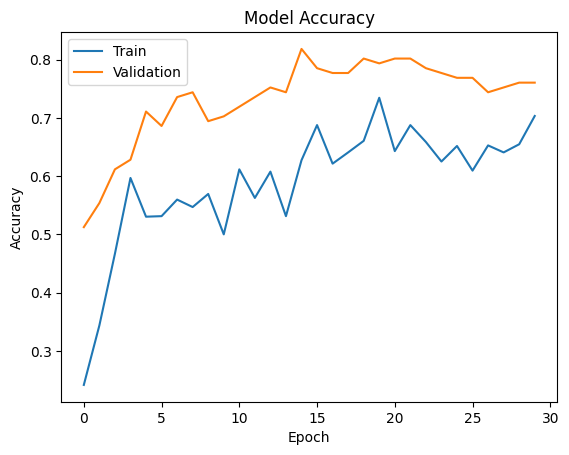

In [124]:
plot(history_xception_aug)

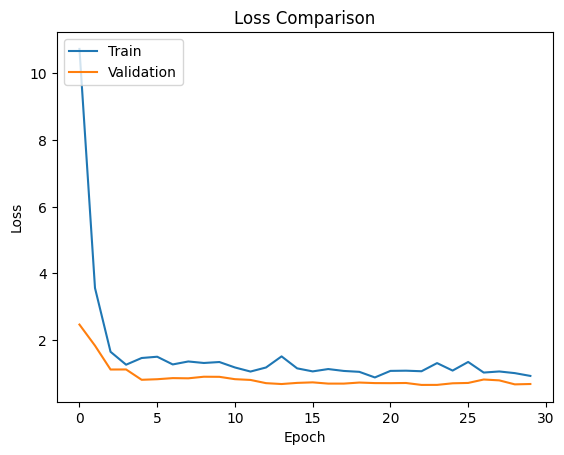

In [127]:
plot_loss(history_xception_aug)

In [125]:
accuracytrain_xception_aug = xception_model_aug.evaluate(X_train_normalized, y_train_encoded, verbose=2)
accuracy_xception_aug = xception_model_aug.evaluate(X_test_normalized, y_test_encoded, verbose=2)
# Here we would get the output as probablities for each category
y_pred_xception_aug=xception_model_aug.predict(X_test_normalized)

34/34 - 3s - 85ms/step - accuracy: 0.8600 - loss: 0.4300


W0000 00:00:1716011265.166978     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 - 2s - 341ms/step - accuracy: 0.8296 - loss: 0.5455


W0000 00:00:1716011266.972148     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

W0000 00:00:1716011269.708536     184 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 707ms/step


W0000 00:00:1716011272.535974     185 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


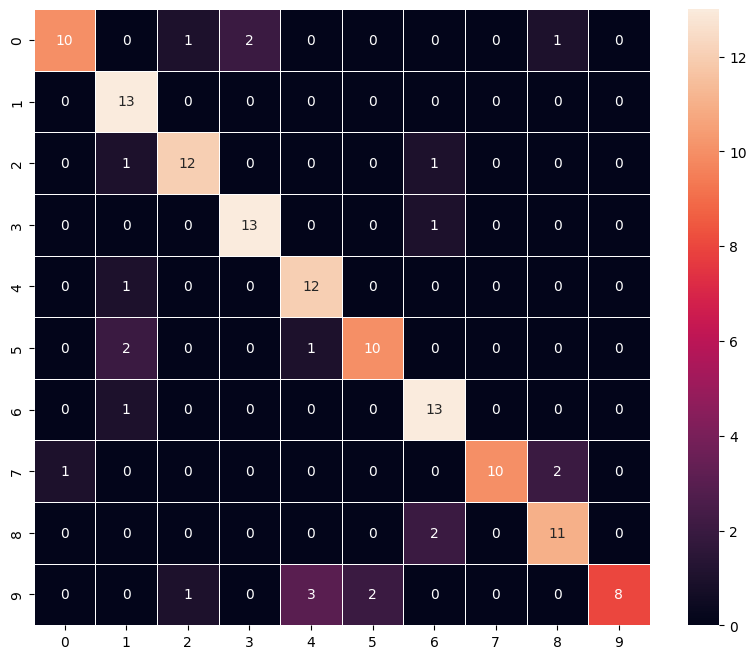

In [126]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg_xception_aug=np.argmax(y_pred_xception_aug,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg_xception_aug)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [128]:
print(classification_report(y_pred=y_pred_arg_xception_aug,y_true = y_test_arg))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80        14
           1       0.72      1.00      0.84        13
           2       0.86      0.86      0.86        14
           3       0.87      0.93      0.90        14
           4       0.75      0.92      0.83        13
           5       0.83      0.77      0.80        13
           6       0.76      0.93      0.84        14
           7       1.00      0.77      0.87        13
           8       0.79      0.85      0.81        13
           9       1.00      0.57      0.73        14

    accuracy                           0.83       135
   macro avg       0.85      0.83      0.83       135
weighted avg       0.85      0.83      0.83       135



In [129]:
result_xception_aug = update_results('Xception with aug',accuracytrain_xception_aug[1],accuracy_xception_aug[1])
results = pd.concat([results, result_xception_aug])
results

Method  Train accuracy  Test accuracy
0                 CNN Simple        0.976980       0.481481
0                CNN Complex        0.999079       0.644444
0   CNN Simple with Data_aug        0.389503       0.355556
0  CNN Complex with Data_aug        0.697053       0.614815
0                      VGG16        1.000000       0.822222
0             VGG16 with aug        0.877532       0.777778
0                   Xception        1.000000       0.859259
0          Xception with aug        0.860037       0.829630

## **Visualizing the prediction:**

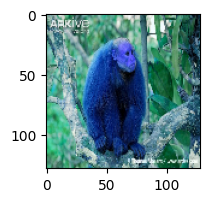

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Label:  bald_uakari
True Label:  bald_uakari




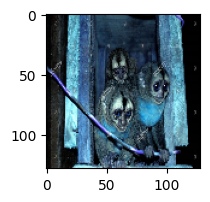

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Label:  black_headed_night_monkey
True Label:  black_headed_night_monkey




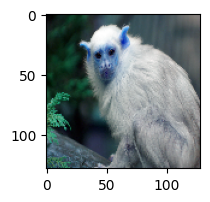

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Label:  silvery_marmoset
True Label:  silvery_marmoset


In [131]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label: ', enc.inverse_transform(xception_model_aug.predict((X_test_normalized[2].reshape(1,height,width,3))))[0])   # reshaping the input image as we are only trying to predict using a single image
print('True Label: ', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector
print("\n")
plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label: ', enc.inverse_transform(xception_model_aug.predict((X_test_normalized[33].reshape(1,height,width,3))))[0])  # reshaping the input image as we are only trying to predict using a single image
print('True Label: ', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector
print("\n")
plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label: ', enc.inverse_transform(xception_model_aug.predict((X_test_normalized[36].reshape(1,height,width,3))))[0])  # reshaping the input image as we are only trying to predict using a single image
print('True Label: ', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

In [141]:
from keras.applications.mobilenet_v2 import MobileNetV2
mobile_model = MobileNetV2(weights='imagenet', include_top = True)
mobile_model.summary()

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_19[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
from keras.applications.mobilenet_v3 import Mobile
MobileNet_model():
    mobile_model = MobileNetV2(weights='imagenet', include_top = False, input_shape = (height,width,3))
    mobile_model.summary()
    # Making all the layers of the VGG model non-trainable. i.e. freezing them
    for layer in mobile_model.layers:
        layer.trainable = False
    new_model = Sequential()

    # Adding the convolutional part of the VGG16 model from above
    new_model.add(mobile_model)

    # Flattening the output of the VGG16 model because it is from a convolutional layer
    new_model.add(Flatten())

    # Adding a dense output layer
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(10, activation='softmax'))
    opt=Adam()
    # Compile model
    new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Generating the summary of the model
    new_model.summary()
    return new_model

## Conclusion
- We can observe from the confusion matrix of all the models that our VGG16 model was the best model because it predicted the majority of the classes better than the other models.
- The test accuracy of the VGG16 model is 63%.
- Data Augmentation has also helped in improving the model.
- Simply employing the transfer learning model can produce a better outcome than any ordinary CNN.

## Scope of Improvement
- These models can be further improved by training with different filter sizes and different number of filters.
- These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64.
- Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance.
- Other Transfer Learning architectures can also be used to train the CNN model and these models can be used for classification.

# **Happy Learning!**